In [1]:
import os
import shutil
import pandas as pd
from pathlib import Path

# Paths configuration

# PATH_ROOT = "/media/tom-ratsakatika/CRUCIAL 4TB/FCC Camera Trap Data"
PATH_ROOT = "/home/tom-ratsakatika/VSCode/camera-traps/data/"

labelled_data_path = Path(PATH_ROOT + 'structured_data_with_deepfaune.xlsx')

df = pd.read_excel(labelled_data_path, sheet_name='structured_data')

df.head()

,Sort,Session,Category,GMU,TrapSite,Longitude,Latitude,Altitude,StartDate,EndDate,...,score,count,humanpresence,FCC_Master_Class,DF(base)_Master_Class,DF(sequence)_Master_Class,FCC_DF(base)_Match,FCC_DF(sequence)_Match,DF(base)_DF(sequence)_Match,Ground_Truth
0,9,1,Systematic monitoring of lynx,34SercaitaBV,Ohaba,25.161698,45.732235,600,2018-02-08,2018-04-09,...,0.97,1,0,Fox,Fox,Fox,True,True,True,Fox
1,9,1,Systematic monitoring of lynx,34SercaitaBV,Ohaba,25.161698,45.732235,600,2018-02-08,2018-04-09,...,0.97,1,0,Fox,Fox,Fox,True,True,True,Fox
2,10,1,Systematic monitoring of lynx,34SercaitaBV,Ohaba,25.161698,45.732235,600,2018-02-08,2018-04-09,...,1.00,0,0,Unknown,Empty**,Empty**,False,False,True,Unknown
3,11,1,Systematic monitoring of lynx,34SercaitaBV,Ohaba,25.161698,45.732235,600,2018-02-08,2018-04-09,...,0.97,0,0,Fox,Empty**,Fox,False,True,False,Fox
4,11,1,Systematic monitoring of lynx,34SercaitaBV,Ohaba,25.161698,45.732235,600,2018-02-08,2018-04-09,...,0.97,1,0,Fox,Fox,Fox,True,True,True,Fox


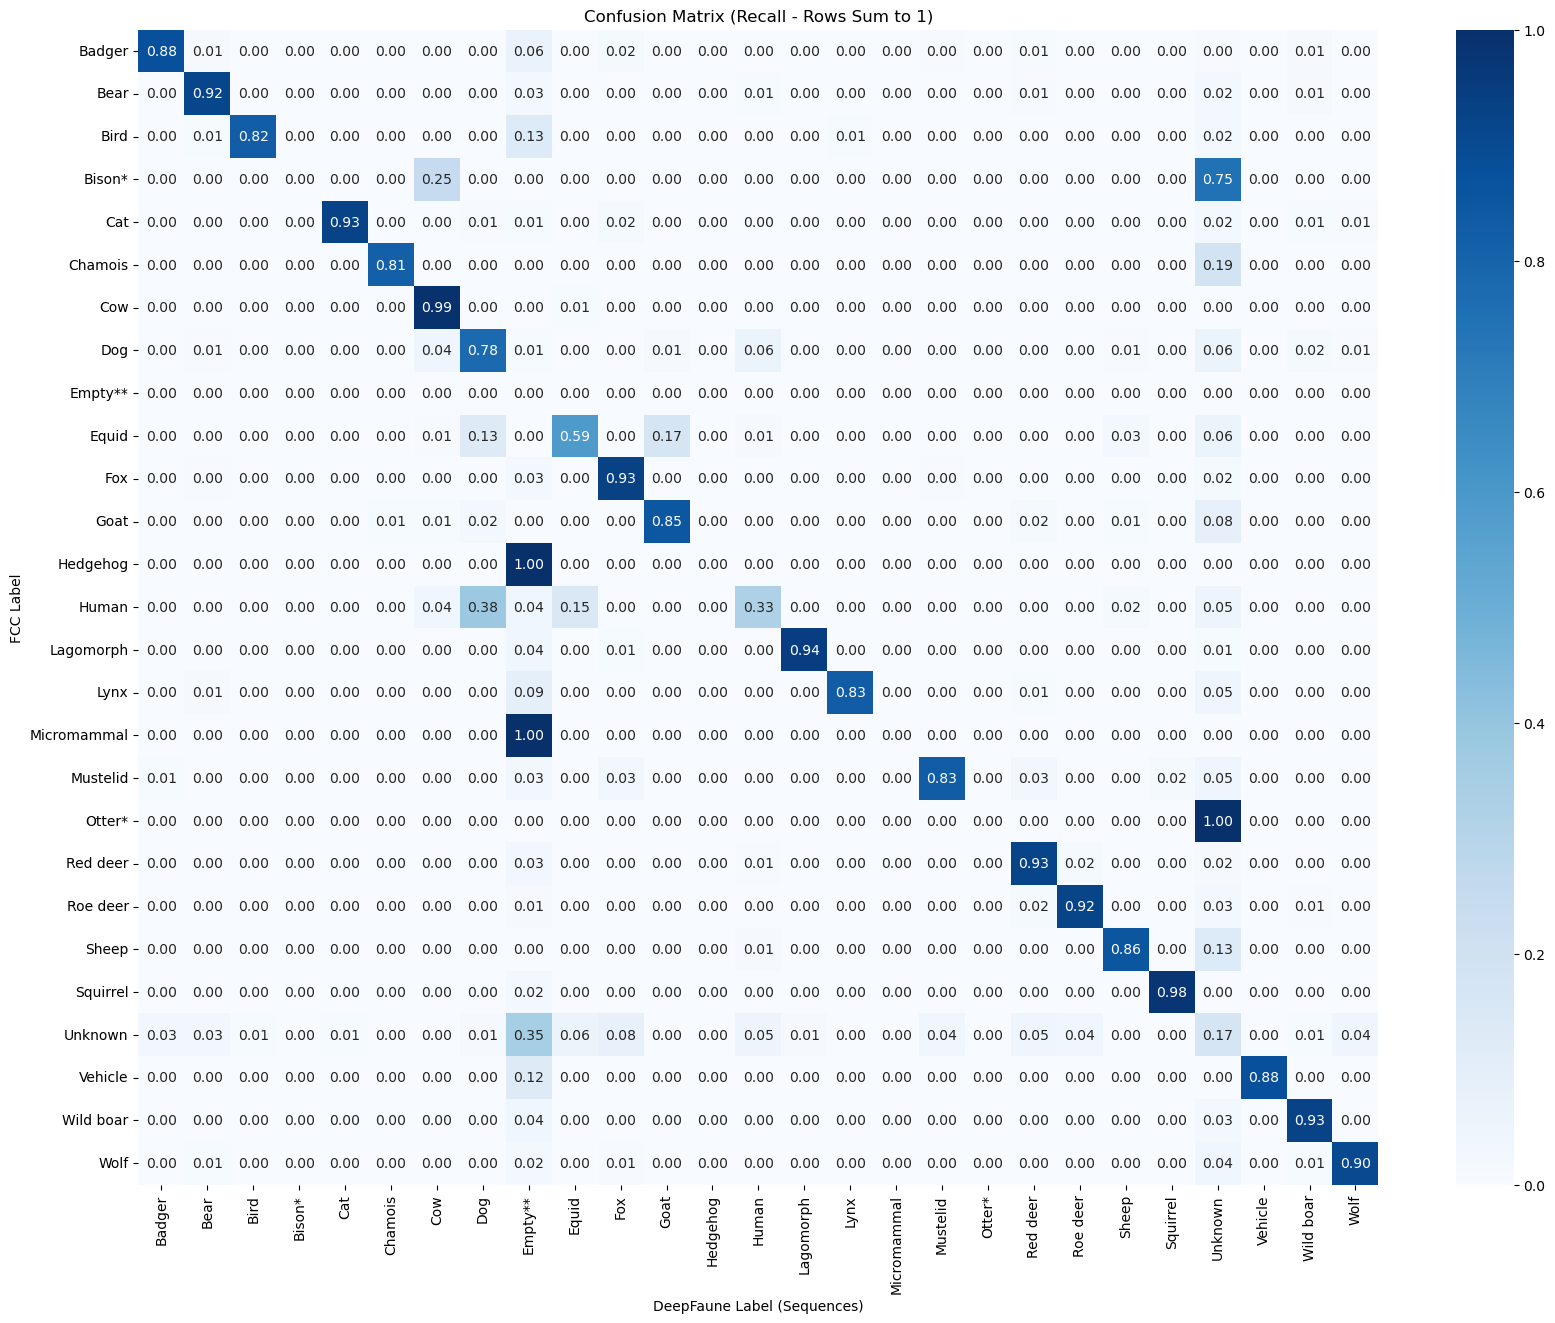

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

y_true = df['FCC_Master_Class']
y_pred = df['DF(sequence)_Master_Class']

# Combine the unique labels from both the prediction and ground truth
labels = np.union1d(y_true.unique(), y_pred.unique())

# Compute the confusion matrix with all labels
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Sum of rows and replacing 0s to prevent division by zero
row_sums = cm.sum(axis=1).reshape(-1, 1)
row_sums[row_sums == 0] = 1  # Prevent division by zero

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / row_sums
cm_normalized = np.nan_to_num(cm_normalized)  # Replace NaN with 0 for classes with no true samples

# Plot the normalized confusion matrix
plt.figure(figsize=(20, 15))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix (Recall - Rows Sum to 1)')
plt.ylabel('FCC Label')
plt.xlabel('DeepFaune Label (Sequences)')
plt.show()


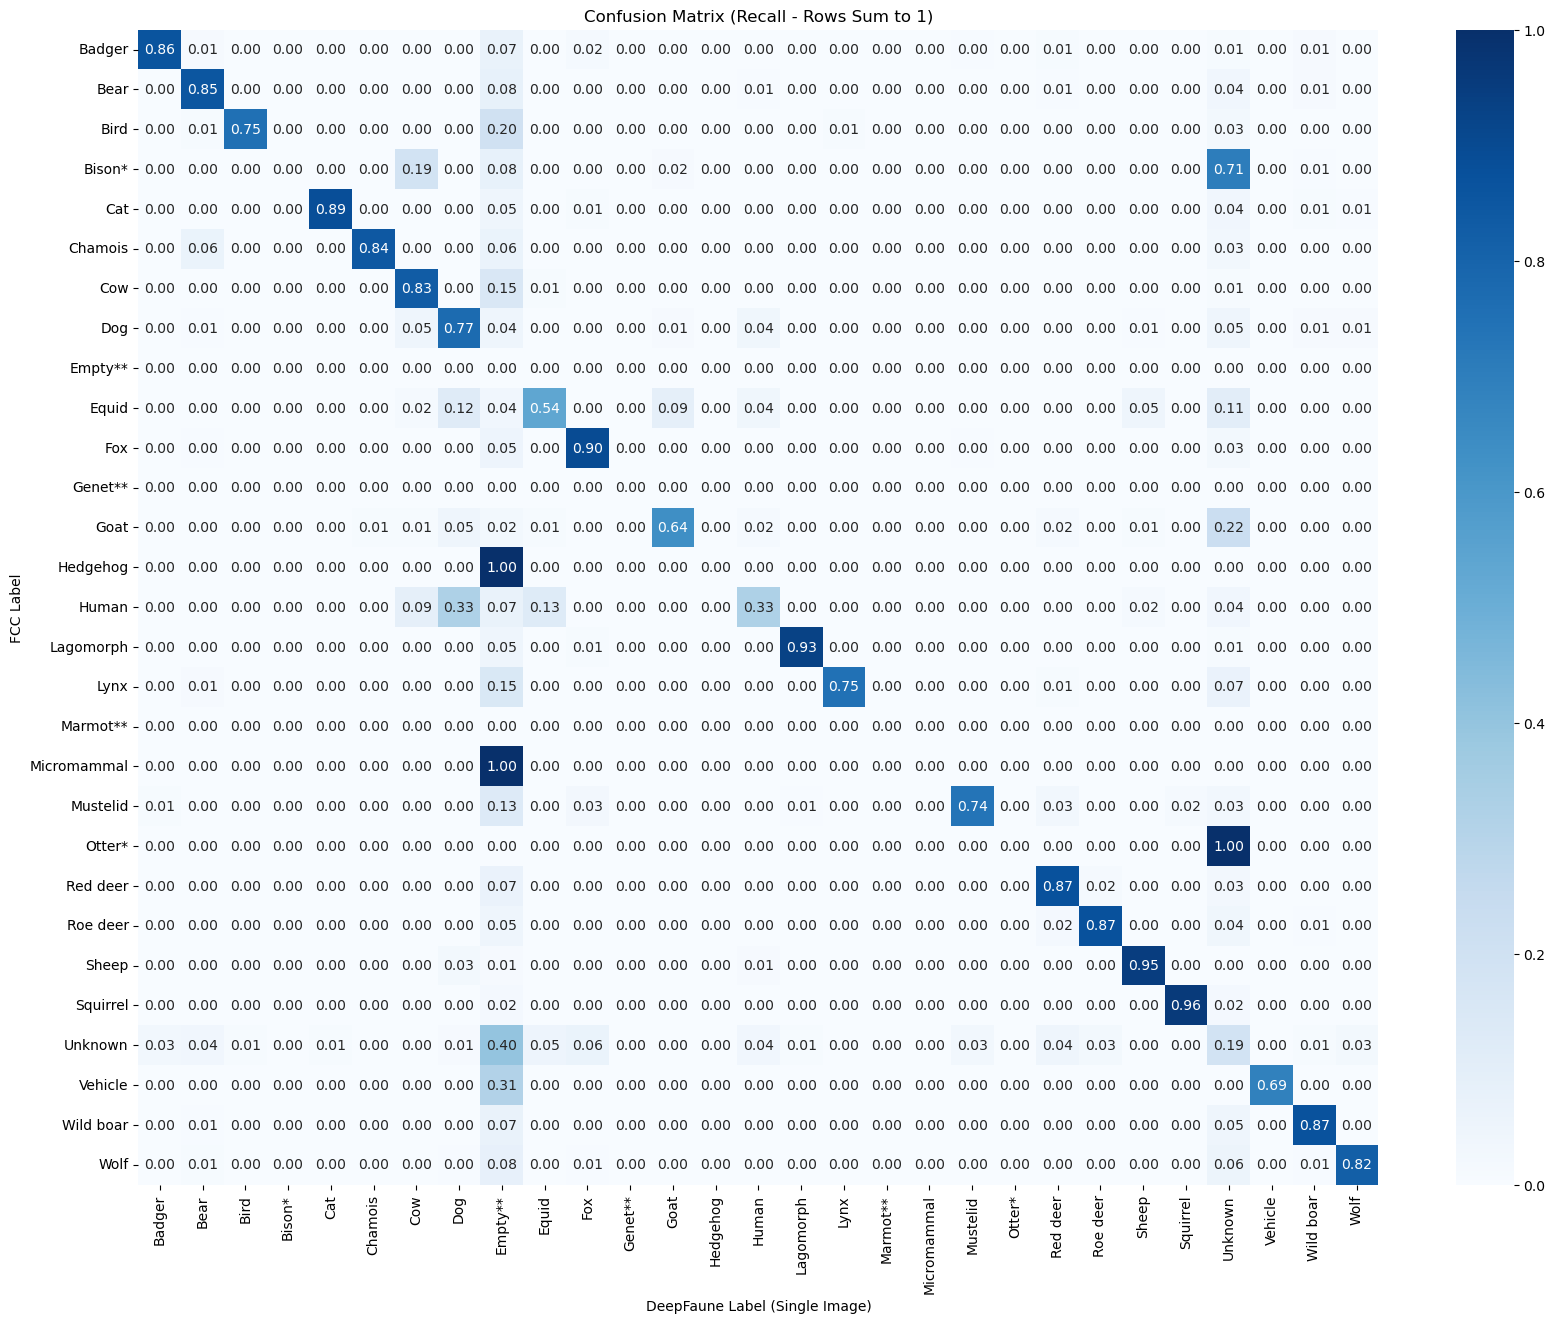

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

y_true = df['FCC_Master_Class']
y_pred = df['DF(base)_Master_Class']

# Combine the unique labels from both the prediction and ground truth
labels = np.union1d(y_true.unique(), y_pred.unique())

# Compute the confusion matrix with all labels
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Sum of rows and replacing 0s to prevent division by zero
row_sums = cm.sum(axis=1).reshape(-1, 1)
row_sums[row_sums == 0] = 1  # Prevent division by zero

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / row_sums
cm_normalized = np.nan_to_num(cm_normalized)  # Replace NaN with 0 for classes with no true samples

# Plot the normalized confusion matrix
plt.figure(figsize=(20, 15))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix (Recall - Rows Sum to 1)')
plt.ylabel('FCC Label')
plt.xlabel('DeepFaune Label (Single Image)')
plt.show()


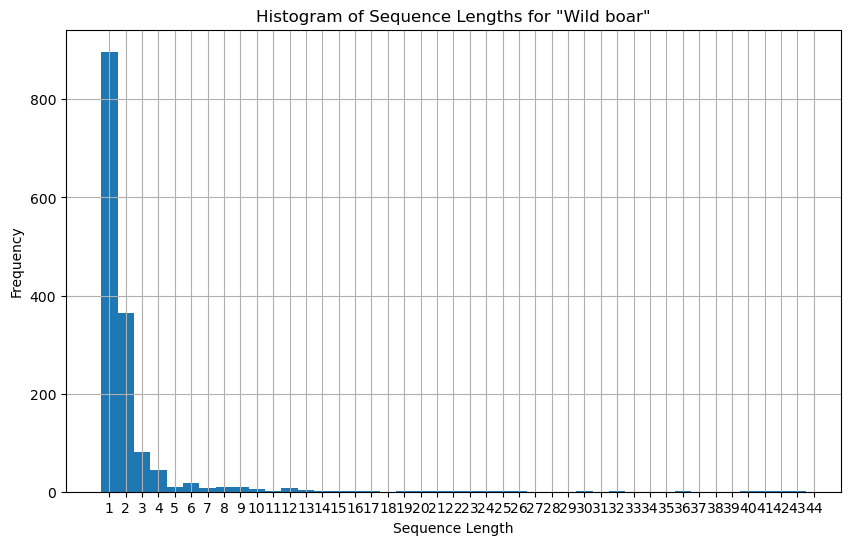

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter for 'Wild boar' predictions
wild_boar_df = df[df['DF(sequence)_Master_Class'] == 'Wild boar']

# Count sequences by 'seqnum' (sequence ID)
# Each 'seqnum' will only have one 'seqcount' value if it identifies the number of images in the sequence
sequence_lengths = wild_boar_df.groupby('seqnum')['seqcount'].first()

# Plot a histogram of the sequence lengths
plt.figure(figsize=(10, 6))
sequence_lengths.hist(bins=range(1, sequence_lengths.max() + 1), align='left')
plt.title('Histogram of Sequence Lengths for "Wild boar"')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.xticks(range(1, sequence_lengths.max() + 1))  # Ensure ticks for each sequence length
plt.grid(True)
plt.show()


In [5]:
import pandas as pd

# Group by both 'DF(sequence)_Master_Class' and 'seqnum' to get unique sequences per species
sequence_data = df.groupby(['DF(sequence)_Master_Class', 'seqnum'])['seqcount'].first().reset_index()

# Calculate total number of sequences per species
num_sequences = sequence_data.groupby('DF(sequence)_Master_Class').size()

# Calculate the number of single image sequences per species
single_image_sequences = sequence_data[sequence_data['seqcount'] == 1].groupby('DF(sequence)_Master_Class').size()

# Group by 'DF(sequence)_Master_Class' to calculate other statistics
df_sequences = sequence_data.groupby('DF(sequence)_Master_Class')['seqcount'].agg(['min', 'max', 'median', 'mean']).reset_index()

# Round the 'mean' for better readability
df_sequences['mean'] = df_sequences['mean'].round(2)

# Add the number of sequences and number of single image sequences as new columns
df_sequences['Number of Sequences'] = df_sequences['DF(sequence)_Master_Class'].map(num_sequences)
df_sequences['Number of Single Image Sequences'] = df_sequences['DF(sequence)_Master_Class'].map(single_image_sequences)

# Calculate the percentage of single image sequences relative to total sequences
df_sequences['% Single Image Sequences'] = (df_sequences['Number of Single Image Sequences'] / df_sequences['Number of Sequences'] * 100).round(2)

# Fill NaN values with 0 for cases where a species has no single image sequences
df_sequences['Number of Single Image Sequences'] = df_sequences['Number of Single Image Sequences'].fillna(0)

# Display the DataFrame
df_sequences

,DF(sequence)_Master_Class,min,max,median,mean,Number of Sequences,Number of Single Image Sequences,% Single Image Sequences
0,Badger,1,7,1.0,1.24,321,270,84.11
1,Bear,1,54,1.0,2.12,1330,704,52.93
2,Bird,1,9,2.0,1.91,289,88,30.45
3,Cat,1,18,1.0,2.09,170,95,55.88
4,Chamois,1,6,2.0,2.25,12,5,41.67
5,Cow,1,48,3.0,5.02,42,4,9.52
6,Dog,1,56,1.0,2.77,188,95,50.53
7,Empty**,1,9,1.0,1.43,552,425,76.99
8,Equid,1,40,3.0,5.92,37,8,21.62
9,Fox,1,12,1.0,1.56,1419,1038,73.15


In [6]:
# Convert DataFrame to LaTeX table
latex_table = df_sequences.to_latex(index=False, column_format='|l|r|r|r|r|r|r|r|')

# Print LaTeX table
print(latex_table)

\begin{tabular}{|l|r|r|r|r|r|r|r|}
\toprule
DF(sequence)_Master_Class & min & max & median & mean & Number of Sequences & Number of Single Image Sequences & % Single Image Sequences \\
\midrule
Badger & 1 & 7 & 1.000000 & 1.240000 & 321 & 270 & 84.110000 \\
Bear & 1 & 54 & 1.000000 & 2.120000 & 1330 & 704 & 52.930000 \\
Bird & 1 & 9 & 2.000000 & 1.910000 & 289 & 88 & 30.450000 \\
Cat & 1 & 18 & 1.000000 & 2.090000 & 170 & 95 & 55.880000 \\
Chamois & 1 & 6 & 2.000000 & 2.250000 & 12 & 5 & 41.670000 \\
Cow & 1 & 48 & 3.000000 & 5.020000 & 42 & 4 & 9.520000 \\
Dog & 1 & 56 & 1.000000 & 2.770000 & 188 & 95 & 50.530000 \\
Empty** & 1 & 9 & 1.000000 & 1.430000 & 552 & 425 & 76.990000 \\
Equid & 1 & 40 & 3.000000 & 5.920000 & 37 & 8 & 21.620000 \\
Fox & 1 & 12 & 1.000000 & 1.560000 & 1419 & 1038 & 73.150000 \\
Goat & 1 & 42 & 4.000000 & 10.250000 & 16 & 1 & 6.250000 \\
Human & 1 & 15 & 2.000000 & 3.120000 & 42 & 14 & 33.330000 \\
Lagomorph & 1 & 9 & 1.000000 & 1.300000 & 88 & 78 & 88.640000 \

In [7]:
# Group by species and sequence number to get unique sequences per species
sequence_data = df.groupby(['DF(sequence)_Master_Class', 'seqnum'])['count'].max().reset_index()

# Calculate total number of sequences per species
num_sequences = sequence_data.groupby('DF(sequence)_Master_Class').size()

# Calculate the maximum count of animals per species
max_animals_count = sequence_data.groupby('DF(sequence)_Master_Class')['count'].max()

# Group by species to calculate other statistics
df_count = sequence_data.groupby('DF(sequence)_Master_Class')['count'].agg(['min', 'max', 'median', 'mean']).reset_index()

# Round the 'mean' for better readability
df_count['mean'] = df_count['mean'].round(2)

# Display the DataFrame
df_count


,DF(sequence)_Master_Class,min,max,median,mean
0,Badger,1,2,1.0,1.01
1,Bear,0,3,1.0,1.10
2,Bird,1,3,1.0,1.19
3,Cat,1,1,1.0,1.00
4,Chamois,1,2,1.0,1.08
5,Cow,1,10,1.0,2.36
6,Dog,1,7,1.0,1.35
7,Empty**,0,0,0.0,0.00
8,Equid,1,4,2.0,1.81
9,Fox,1,2,1.0,1.01


In [8]:
# Convert DataFrame to LaTeX table
latex_table = df_count.to_latex(index=False, column_format='|l|r|r|r|r|')

# Print LaTeX table
print(latex_table)


\begin{tabular}{|l|r|r|r|r|}
\toprule
DF(sequence)_Master_Class & min & max & median & mean \\
\midrule
Badger & 1 & 2 & 1.000000 & 1.010000 \\
Bear & 0 & 3 & 1.000000 & 1.100000 \\
Bird & 1 & 3 & 1.000000 & 1.190000 \\
Cat & 1 & 1 & 1.000000 & 1.000000 \\
Chamois & 1 & 2 & 1.000000 & 1.080000 \\
Cow & 1 & 10 & 1.000000 & 2.360000 \\
Dog & 1 & 7 & 1.000000 & 1.350000 \\
Empty** & 0 & 0 & 0.000000 & 0.000000 \\
Equid & 1 & 4 & 2.000000 & 1.810000 \\
Fox & 1 & 2 & 1.000000 & 1.010000 \\
Goat & 1 & 21 & 5.500000 & 7.000000 \\
Human & 1 & 4 & 1.000000 & 1.570000 \\
Lagomorph & 1 & 1 & 1.000000 & 1.000000 \\
Lynx & 0 & 3 & 1.000000 & 1.030000 \\
Mustelid & 1 & 1 & 1.000000 & 1.000000 \\
Red deer & 0 & 4 & 1.000000 & 1.120000 \\
Roe deer & 1 & 3 & 1.000000 & 1.160000 \\
Sheep & 1 & 21 & 5.000000 & 6.900000 \\
Squirrel & 1 & 1 & 1.000000 & 1.000000 \\
Unknown & 0 & 15 & 1.000000 & 1.220000 \\
Vehicle & 1 & 2 & 1.000000 & 1.330000 \\
Wild boar & 0 & 15 & 1.000000 & 1.310000 \\
Wolf & 1 & 4 & 1

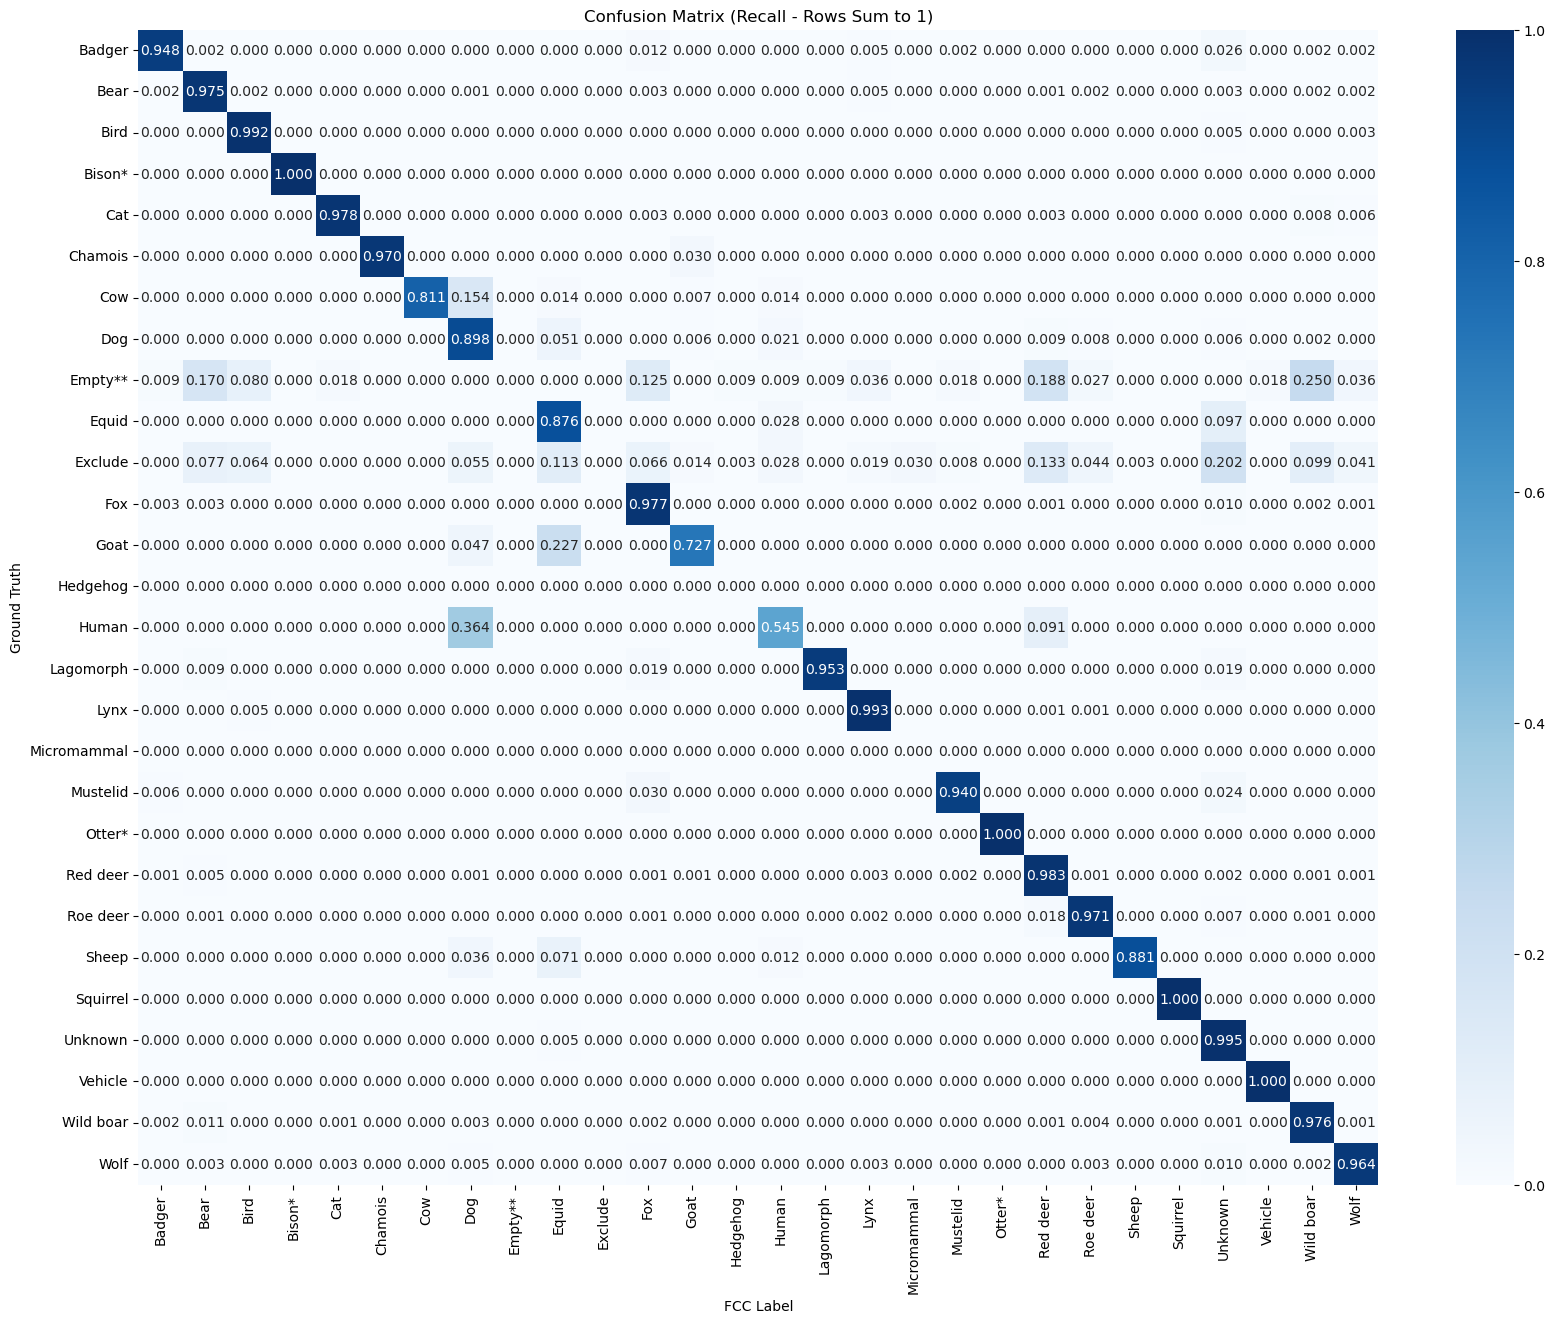

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

y_true = df['Ground_Truth']
y_pred = df['FCC_Master_Class']

# Filter out the 'Neither' class from both y_true and y_pred
mask = (y_true != 'Neither') & (y_pred != 'Neither')
y_true = y_true[mask]
y_pred = y_pred[mask]

# Combine the unique labels from both the prediction and ground truth
labels = np.union1d(y_true.unique(), y_pred.unique())

# Compute the confusion matrix with all labels
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Sum of rows and replacing 0s to prevent division by zero
row_sums = cm.sum(axis=1).reshape(-1, 1)
row_sums[row_sums == 0] = 1  # Prevent division by zero

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / row_sums
cm_normalized = np.nan_to_num(cm_normalized)  # Replace NaN with 0 for classes with no true samples

# Plot the normalized confusion matrix
plt.figure(figsize=(20, 15))
sns.heatmap(cm_normalized, annot=True, fmt=".3f", cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix (Recall - Rows Sum to 1)')
plt.ylabel('Ground Truth')
plt.xlabel('FCC Label')
plt.show()


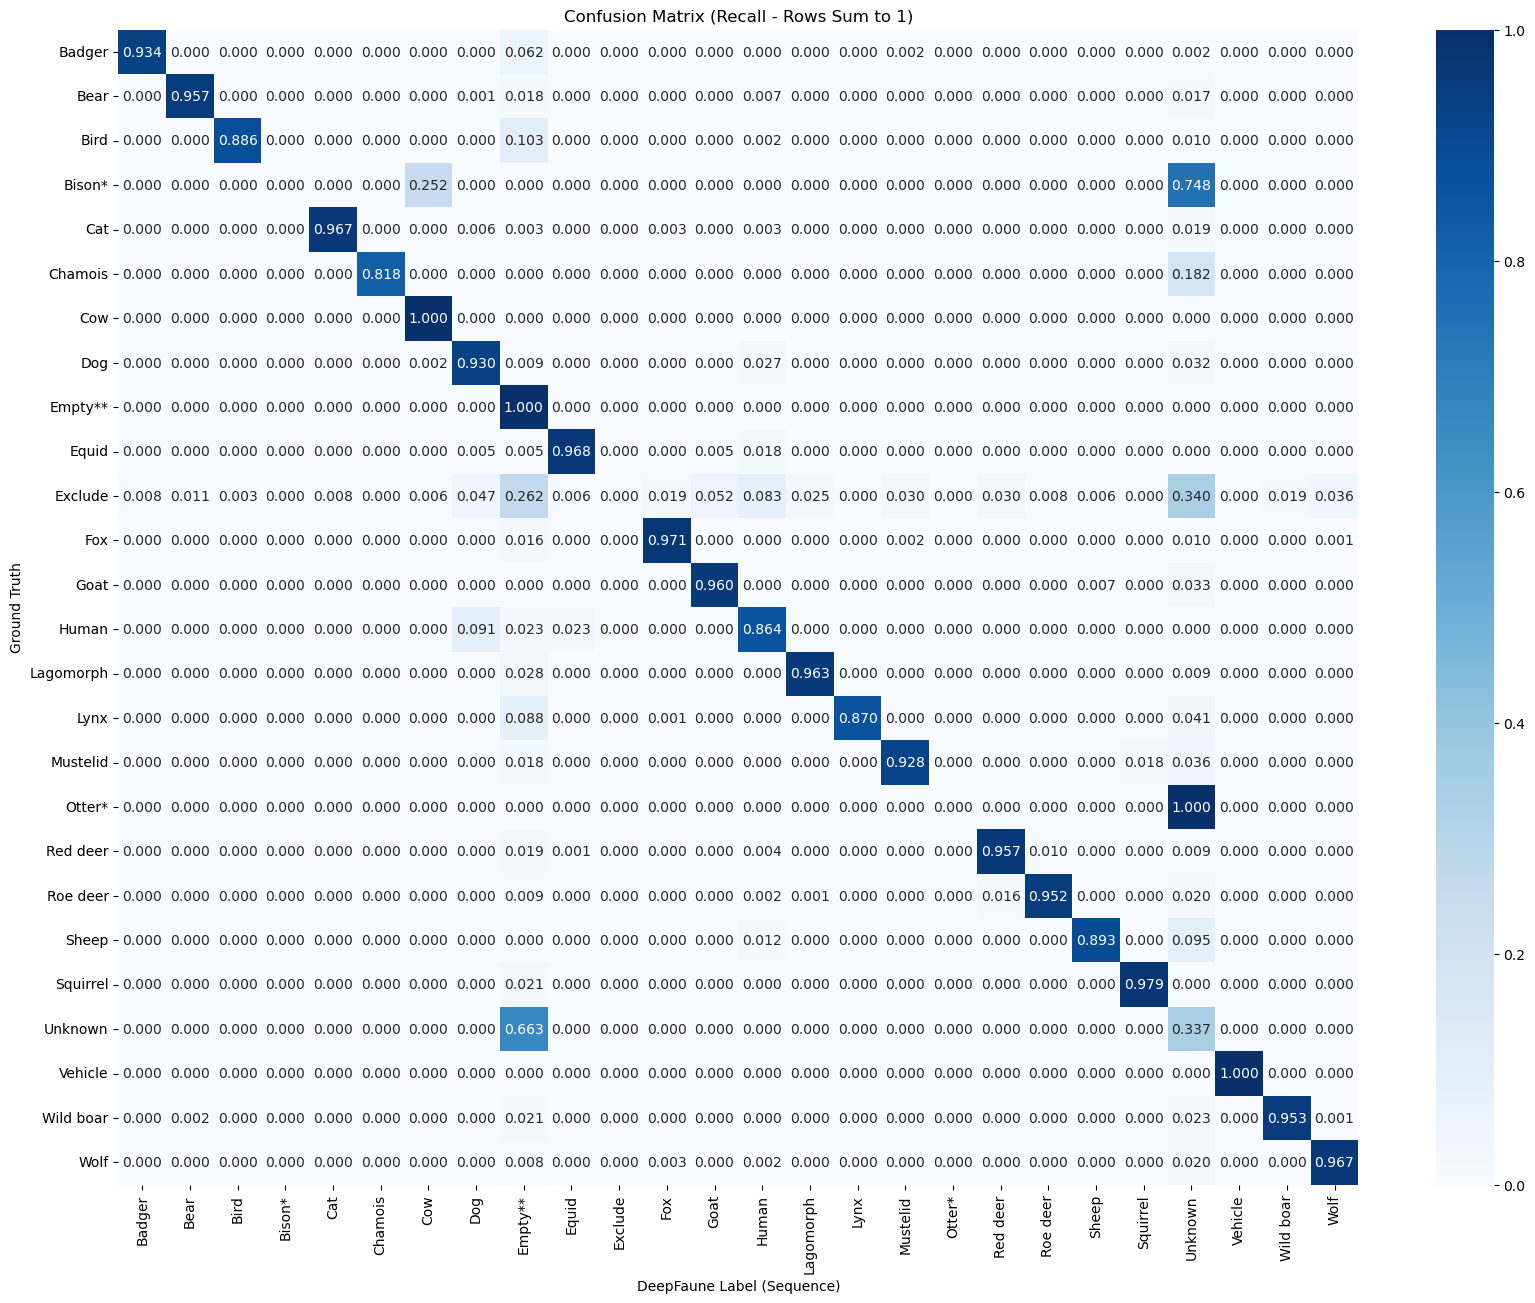

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

y_true = df['Ground_Truth']
y_pred = df['DF(sequence)_Master_Class']

# Filter out the 'Neither' class from both y_true and y_pred
mask = (y_true != 'Neither') & (y_pred != 'Neither')
y_true = y_true[mask]
y_pred = y_pred[mask]

# Combine the unique labels from both the prediction and ground truth
labels = np.union1d(y_true.unique(), y_pred.unique())

# Compute the confusion matrix with all labels
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Sum of rows and replacing 0s to prevent division by zero
row_sums = cm.sum(axis=1).reshape(-1, 1)
row_sums[row_sums == 0] = 1  # Prevent division by zero

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / row_sums
cm_normalized = np.nan_to_num(cm_normalized)  # Replace NaN with 0 for classes with no true samples

# Plot the normalized confusion matrix
plt.figure(figsize=(20, 15))
sns.heatmap(cm_normalized, annot=True, fmt=".3f", cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix (Recall - Rows Sum to 1)')
plt.ylabel('Ground Truth')
plt.xlabel('DeepFaune Label (Sequence)')
plt.show()

In [11]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder

# Filter the DataFrame to exclude "Unknown", "Exclude", and "Neither" only from the Ground_Truth column
df_filtered = df[~df['Ground_Truth'].isin(['Unknown', 'Exclude', 'Neither'])]

# Collect all unique classes from ground truth and predictions
all_classes = pd.Series(pd.concat([df_filtered['Ground_Truth'], df_filtered['FCC_Master_Class'], df_filtered['DF(sequence)_Master_Class']]).unique())

# Encode all labels
le = LabelEncoder()
le.fit(all_classes)

# Transform all columns using the same encoder
ground_truth_encoded = le.transform(df_filtered['Ground_Truth'])
human_predictions_encoded = le.transform(df_filtered['FCC_Master_Class'])
model_predictions_encoded = le.transform(df_filtered['DF(sequence)_Master_Class'])

# Get list of class labels from the encoder
classes = le.classes_

# Calculate Precision, Recall, F1 Score, and Support for human predictions
metrics_human = precision_recall_fscore_support(ground_truth_encoded, human_predictions_encoded, labels=range(len(classes)), zero_division=0)
precision_human = metrics_human[0]
recall_human = metrics_human[1]
f1_human = metrics_human[2]
support_human = metrics_human[3]

# Calculate Precision, Recall, F1 Score, and Support for model predictions
metrics_model = precision_recall_fscore_support(ground_truth_encoded, model_predictions_encoded, labels=range(len(classes)), zero_division=0)
precision_model = metrics_model[0]
recall_model = metrics_model[1]
f1_model = metrics_model[2]
support_model = metrics_model[3]

# Prepare data for table display
results = []
for i, class_label in enumerate(classes):
    results.append({
        'Class': class_label,
        'n': support_human[i],
        'Human Precision': "-" if precision_human[i] == 0 else precision_human[i],
        'Human Recall': "-" if recall_human[i] == 0 else recall_human[i],
        'Human F1 Score': "-" if f1_human[i] == 0 else f1_human[i],
        'Model Precision': "-" if precision_model[i] == 0 else precision_model[i],
        'Model Recall': "-" if recall_model[i] == 0 else recall_model[i],
        'Model F1 Score': "-" if f1_model[i] == 0 else f1_model[i]
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df

,Class,n,Human Precision,Human Recall,Human F1 Score,Model Precision,Model Recall,Model F1 Score
0,Badger,422,0.945626,0.947867,0.946746,0.994949,0.933649,0.963325
1,Bear,2936,0.971836,0.975477,0.973653,0.997869,0.956744,0.976874
2,Bird,621,0.965517,0.991948,0.978554,1.0,0.885668,0.939368
3,Bison*,258,1.0,1.0,1.0,-,-,-
4,Cat,362,0.975207,0.977901,0.976552,1.0,0.966851,0.983146
5,Chamois,33,1.0,0.969697,0.984615,1.0,0.818182,0.9
6,Cow,143,1.0,0.811189,0.895753,0.684211,1.0,0.8125
7,Dog,528,0.877778,0.897727,0.88764,0.982,0.929924,0.955253
8,Empty**,112,-,-,-,0.198934,1.0,0.331852
9,Equid,217,0.733591,0.875576,0.798319,0.972222,0.967742,0.969977


In [12]:
# Convert DataFrame to LaTeX
latex_table = results_df.to_latex(index=False, column_format='lccccccc', float_format="%.2f", formatters={
    'Human Precision': lambda x: f'{x:.2f}' if isinstance(x, float) else x,
    'Human Recall': lambda x: f'{x:.2f}' if isinstance(x, float) else x,
    'Human F1 Score': lambda x: f'{x:.2f}' if isinstance(x, float) else x,
    'Model Precision': lambda x: f'{x:.2f}' if isinstance(x, float) else x,
    'Model Recall': lambda x: f'{x:.2f}' if isinstance(x, float) else x,
    'Model F1 Score': lambda x: f'{x:.2f}' if isinstance(x, float) else x,
    'n': lambda x: f'{x:.0f}'  # Output integer format for 'n'
})

print(latex_table)

\begin{tabular}{lccccccc}
\toprule
Class & n & Human Precision & Human Recall & Human F1 Score & Model Precision & Model Recall & Model F1 Score \\
\midrule
Badger & 422 & 0.95 & 0.95 & 0.95 & 0.99 & 0.93 & 0.96 \\
Bear & 2936 & 0.97 & 0.98 & 0.97 & 1.00 & 0.96 & 0.98 \\
Bird & 621 & 0.97 & 0.99 & 0.98 & 1.00 & 0.89 & 0.94 \\
Bison* & 258 & 1.00 & 1.00 & 1.00 & - & - & - \\
Cat & 362 & 0.98 & 0.98 & 0.98 & 1.00 & 0.97 & 0.98 \\
Chamois & 33 & 1.00 & 0.97 & 0.98 & 1.00 & 0.82 & 0.90 \\
Cow & 143 & 1.00 & 0.81 & 0.90 & 0.68 & 1.00 & 0.81 \\
Dog & 528 & 0.88 & 0.90 & 0.89 & 0.98 & 0.93 & 0.96 \\
Empty** & 112 & - & - & - & 0.20 & 1.00 & 0.33 \\
Equid & 217 & 0.73 & 0.88 & 0.80 & 0.97 & 0.97 & 0.97 \\
Fox & 2256 & 0.98 & 0.98 & 0.98 & 1.00 & 0.97 & 0.98 \\
Goat & 150 & 0.94 & 0.73 & 0.82 & 0.99 & 0.96 & 0.98 \\
Hedgehog & 0 & - & - & - & - & - & - \\
Human & 44 & 0.53 & 0.55 & 0.54 & 0.38 & 0.86 & 0.53 \\
Lagomorph & 107 & 0.98 & 0.95 & 0.97 & 0.98 & 0.96 & 0.97 \\
Lynx & 1147 & 0.97 & 0.9